In [15]:
import pandas as pd
import json
import numpy as np
import re
from sklearn.model_selection import train_test_split
!pip install transformers sentencepiece torch
#!pip uninstall -y nltk
!pip install nltk==3.8.1
from transformers import MT5ForConditionalGeneration, MT5Tokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


import torch

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


RuntimeError: Failed to import transformers.models.mt5.modeling_mt5 because of the following error (look up to see its traceback):
Failed to import transformers.generation.utils because of the following error (look up to see its traceback):
module 'torch' has no attribute 'version'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp "/content/drive/MyDrive/Kufale.json" "/content/Kufale.json"
!cp "/content/drive/MyDrive/ግዕዝ_ጥያቄ_ወአውስኦ.csv" "/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv"
!cp "/content/drive/MyDrive/geez_tigrigna.csv" "/content/geez_tigrigna.csv"

In [ ]:
!ls /content  # Should show dataset1, dataset2, dataset3

drive  geez_tigrigna.csv  Kufale.json  sample_data  ግዕዝ_ጥያቄ_ወአውስኦ.csv


In [9]:
drive.flush_and_unmount()

In [ ]:
!ls /content/geez_Chat_Bot


ls: cannot access '/content/geez_Chat_Bot': No such file or directory


In [10]:
import json
import pandas as pd
from pprint import pprint
# Load the translation dataset
with open('/content/Kufale.json', 'r', encoding='utf-8') as f:
    translation_data = json.load(f)
# Load the Q&A dataset
qa_data = pd.read_csv('/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv', encoding='utf-8')
# Examine the datasets
print("Translation Data Sample:")
print(translation_data[:10])

print("\nQ&A Data Sample:")
print(qa_data.head(10))


# Load only the columns you need (ግዕዝ and ትግርኛ)
tig_df = pd.read_csv("/content/geez_tigrigna.csv", usecols=["ግዕዝ ", "ትግርኛ "])  # ← Note the spaces!
# Verify
print(tig_df.head(10))

Translation Data Sample:
[{'gez': 'ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለኢዮቤልውሳቲሆሙ ውስተ ኵሉ ዓመታተ ዓለም በከመ ተናገሮ ለሙሴ በደብረ ሲና አመ ዐርገ ይንሣእ ጽላተ እብን ሕግ ወትእዛዝ በቃለ እግዚአብሔር በከመ ይቤሎ ይዕርግ ውስተ ርእሰ ደብር።', 'eng': 'These are the words regarding the divisions of the times of the law and of the testimony, of the events of the years, of the weeks of their jubilees throughout all the years of eternity as he related (them) to Moses on Mt. Sinai when he went up to receive the stone tablets — the law and the commandments — on the Lord’s orders as he had told him that he should come up to the summit of the mountain.'}, {'gez': 'ወኮነ በቀዳሚ ዓመት በፀአቶሙ ለደቂቀ እስራኤል እምነ ግብጽ በወርኅ ሣልስ አመ ዐሡሩ ወሰዱሱ ለውእቱ ወርኅ ተናገሮ እግዚአብሔር ለሙሴ እንዘ ይብል ዕርግ ኀቤየ ውስተ ደብር ወእሁበከ ክልኤ ጽላተ እብን ዘሕግ ወዘትእዛዝ ዘመጠነ ጸሐፍኩ ታለብዎሙ።', 'eng': 'During the first year of the Israelites’ exodus from Egypt, in the third month — on the sixteenth of the month — the Lord said to Moses: Come up to me on the mountain. I will give you the two stone tablets of the law 

In [11]:
import re
import nltk
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize

# Download all required NLTK data with verification
def download_nltk_resources():
    try:
        nltk.download('punkt', quiet=True)
        # Verify punkt resources are available
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading NLTK punkt resources...")
        nltk.download('punkt', quiet=False)
        nltk.download('punkt_tab', quiet=False)  # Additional required resource

download_nltk_resources()

def clean_geez_text(text):
    """Enhanced cleaner for Ge'ez text with proper Unicode handling"""
    if not isinstance(text, str):
        return ''
    # Ge'ez-specific cleaning
    text = text.strip()
    text = re.sub(r'[\u1369-\u137C]', '', text)  # Remove Ethiopic numbers
    text = re.sub(r'[^\w\s\u1200-\u137F]', '', text)  # Keep only Ge'ez chars and whitespace
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text

def preprocess_translation_data(translation_data):
    """Process translation data with Ge'ez-specific handling"""
    preprocessed = []
    for pair in translation_data:
        # Clean both Ge'ez and English text
        geez = clean_geez_text(pair.get('gez', ''))
        english = clean_geez_text(pair.get('eng', ''))  # English also cleaned

        # Tokenize with error handling
        try:
            geez_tokens = word_tokenize(geez) if geez else []
            english_tokens = word_tokenize(english) if english else []
        except:
            geez_tokens = []
            english_tokens = []

        preprocessed.append({
            'gez_original': pair.get('gez', ''),
            'eng_original': pair.get('eng', ''),
            'gez_cleaned': geez,
            'eng_cleaned': english,
            'gez_tokens': geez_tokens,
            'eng_tokens': english_tokens,
            'gez_length': len(geez_tokens),
            'eng_length': len(english_tokens)
        })
    return preprocessed

def analyze_translation_data(df):
    """Generate insights about the translation dataset"""
    print("\nTranslation Dataset Analysis:")
    print(f"Total pairs: {len(df)}")

    # Token statistics for Ge'ez
    all_geez_tokens = [token for sublist in df['gez_tokens'] for token in sublist]
    geez_vocab = Counter(all_geez_tokens)
    print(f"Unique Ge'ez tokens: {len(geez_vocab)}")
    print(f"Most common Ge'ez tokens: {geez_vocab.most_common(10)}")
    print(f"Average Ge'ez length: {df['gez_length'].mean():.1f} tokens")

    # English statistics
    all_eng_tokens = [token for sublist in df['eng_tokens'] for token in sublist]
    eng_vocab = Counter(all_eng_tokens)
    print(f"\nUnique English tokens: {len(eng_vocab)}")
    print(f"Most common English tokens: {eng_vocab.most_common(10)}")
    print(f"Average English length: {df['eng_length'].mean():.1f} tokens")

# Example usage with valid data
translation_data = [
    {'gez': 'ሰላም ለከ', 'eng': 'Hello'},
    {'gez': 'እንቋዕ ዳህና መጻእከ', 'eng': 'Welcome'},
    {'gez': 'ፍሱህ ጥቀ! 123', 'eng': 'Very happy! 123'},
]

# Process and analyze
preprocessed = preprocess_translation_data(translation_data)
translation_df = pd.DataFrame(preprocessed)

# Keep only rows with at least one non-empty text
translation_df = translation_df[
    (translation_df['gez_length'] > 0) |
    (translation_df['eng_length'] > 0)
]

analyze_translation_data(translation_df)
print("\nProcessed Data Sample:")
print(translation_df.head().to_markdown(index=False))


Translation Dataset Analysis:
Total pairs: 0
Unique Ge'ez tokens: 0
Most common Ge'ez tokens: []
Average Ge'ez length: nan tokens

Unique English tokens: 0
Most common English tokens: []
Average English length: nan tokens

Processed Data Sample:
| gez_original   | eng_original   | gez_cleaned   | eng_cleaned   | gez_tokens   | eng_tokens   | gez_length   | eng_length   |
|----------------|----------------|---------------|---------------|--------------|--------------|--------------|--------------|


In [13]:
import re
import json
import pandas as pd

# ========== 1. Define your custom Geez stopwords ==========

custom_geez_stopwords = set("""
እስመ ውስተ አምጣነ አኮኑ እመ አመ በ ለ ከመ ጊዜ እንበለ ዘ እንተ እለ ለለ ከመከመ ሀበሀበ
በበ እንዘ ዘዘ ሀበ መንገለ ወእደ ህየንተ በይነ እንበይነ ፍዳ መጠነ ዐቅመ በቀለ አምሳለ
ጽላሎተ መዋዕለ አያተ እንዘእንዘ ወ
""".split())

# ========== 2. Define preprocessing function ==========

def preprocess_geez_text(text):
    if not isinstance(text, str):
        return ""

    # Remove Geez numerals (if needed) and punctuation
    text = re.sub(r'[\u1369-\u137C]', '', text)  # Remove Geez numerals
    text = re.sub(r'[።፣፤፥፦]', ' ', text)  # Remove Geez punctuation marks
    text = re.sub(r'[^\w\s]', '', text)  # Remove any other punctuation marks

    # Tokenize the text into words (using spaces as the delimiter)
    tokens = text.split()

    # Remove stopwords based on the custom list (ensure no extra spaces in the list)
    cleaned_tokens = [word for word in tokens if word.strip() not in custom_geez_stopwords]

    # Join the cleaned tokens back into a single string and return
    return ' '.join(cleaned_tokens)

def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower().strip()

# ========== 3. Load and process kufale.json ==========

with open('/content/Kufale.json', 'r', encoding='utf-8') as f:
    kufale_data = json.load(f)

# Apply the preprocessing functions to both the Geez and English text fields
for item in kufale_data:
    item['geez_processed'] = preprocess_geez_text(item['gez'])
    item['english_processed'] = preprocess_english_text(item['eng'])

# Convert the processed data into a DataFrame
kufale_df = pd.DataFrame(kufale_data)

# ========== 4. Load and process ግዕዝ_ጥያቄ_ወአውስኦ.csv ==========

qa_df = pd.read_csv('/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv', encoding='utf-8')

# Apply the preprocessing function to the question and answer columns
qa_df['question_processed'] = qa_df['ጥያቄ'].apply(preprocess_geez_text)
qa_df['answer_processed'] = qa_df['አውስኦ'].apply(preprocess_geez_text)

# ========== 5. Optional: Show results ==========

print(kufale_df[['gez', 'geez_processed']].head())
print(qa_df[['ጥያቄ', 'question_processed']].head())


                                                 gez  \
0  ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለ...   
1  ወኮነ በቀዳሚ ዓመት በፀአቶሙ ለደቂቀ እስራኤል እምነ ግብጽ በወርኅ ሣልስ...   
2  ወዐርገ ሙሴ ውስተ ደብረ እግዚአብሔር ወኀደረ ስብሐተ እግዚአብሔር ውስተ ...   
3  ወጸውዖ ለሙሴ በዕለተ ሳብዕት በማእከለ ደመና ወርእየ ስብሐተ እግዚአብሔር...   
4  ወሀሎ ሙሴ ውስተ ደብር አርብዓ ዕለተ ወአርብዓ ሌሊተ ወአመሮ እግዚአብሔር...   

                                      geez_processed  
0  ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለ...  
1  ወኮነ በቀዳሚ ዓመት በፀአቶሙ ለደቂቀ እስራኤል እምነ ግብጽ በወርኅ ሣልስ...  
2  ወዐርገ ሙሴ ደብረ እግዚአብሔር ወኀደረ ስብሐተ እግዚአብሔር ደብረ ሲና ወ...  
3  ወጸውዖ ለሙሴ በዕለተ ሳብዕት በማእከለ ደመና ወርእየ ስብሐተ እግዚአብሔር...  
4  ወሀሎ ሙሴ ደብር አርብዓ ዕለተ ወአርብዓ ሌሊተ ወአመሮ እግዚአብሔር ዘቀዳ...  
             ጥያቄ question_processed
0       እፎ ሀደርከ?            እፎ ሀደርከ
1       እፎ ወዓልከ?            እፎ ወዓልከ
2    ሰላም ለከ እሁየ?         ሰላም ለከ እሁየ
3  ኦ ኡሁየ መኑ ስምከ?       ኦ ኡሁየ መኑ ስምከ
4     ማዕዜ ተወለድከ?          ማዕዜ ተወለድከ


In [ ]:
#!pip uninstall -y nltk
#!pip install nltk==3.8.1



Found existing installation: nltk 3.8.1
Uninstalling nltk-3.8.1:
  Successfully uninstalled nltk-3.8.1
  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
textblob 0.19.0 requires nltk>=3.9, but you have nltk 3.8.1 which is incompatible.


In [4]:
import pandas as pd
import json
import re
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import nltk

# Download punkt properly
nltk.download('punkt')
# If you also use stopwords, add this
nltk.download('stopwords')
# Download NLTK data
nltk.download('punkt')

def clean_geez_text(text):
    """Specialized cleaner for Ge'ez text"""
    if not isinstance(text, str):
        return ''

    # Ge'ez-specific cleaning
    text = text.strip()
    text = re.sub(r'[\u1369-\u137C]', '', text)  # Remove Ethiopic numbers
    text = re.sub(r'[^\w\s\u1200-\u137F]', '', text)  # Keep only Ge'ez chars and whitespace
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text

def preprocess_translation_data(json_path):
    """Process the Kufale.json translation dataset"""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame(data)

    # Clean and tokenize
    df['gez_cleaned'] = df['gez'].apply(clean_geez_text)
    df['eng_cleaned'] = df['eng'].apply(clean_geez_text)  # Also clean English side

    df['gez_tokens'] = df['gez_cleaned'].apply(word_tokenize)
    df['eng_tokens'] = df['eng_cleaned'].apply(word_tokenize)

    return df

def preprocess_qa_data(csv_path):
    """Process the Q&A dataset"""
    qa_df = pd.read_csv(csv_path, encoding='utf-8')

    # Validate columns
    required_columns = {'ጥያቄ', 'አውስኦ'}
    if not required_columns.issubset(qa_df.columns):
        raise ValueError(f"CSV must contain {required_columns} columns")

    # Clean and tokenize
    qa_df['question_cleaned'] = qa_df['ጥያቄ'].apply(clean_geez_text)
    qa_df['answer_cleaned'] = qa_df['አውስኦ'].apply(clean_geez_text)

    qa_df['question_tokens'] = qa_df['question_cleaned'].apply(word_tokenize)
    qa_df['answer_tokens'] = qa_df['answer_cleaned'].apply(word_tokenize)

    # Add length features
    qa_df['question_length'] = qa_df['question_tokens'].apply(len)
    qa_df['answer_length'] = qa_df['answer_tokens'].apply(len)

    return qa_df

def preprocess_geez_tigrigna_data(csv_path):
    """Process the Geez-Tigrigna dataset"""
    gt_df = pd.read_csv(csv_path, encoding='utf-8')

    # Validate columns
    required_columns = {'ግዕዝ ', 'ትግርኛ '}
    if not required_columns.issubset(gt_df.columns):
        raise ValueError(f"CSV must contain {required_columns} columns")

    # Clean and tokenize
    gt_df['geez_cleaned'] = gt_df['ግዕዝ '].apply(clean_geez_text)
    gt_df['tigrigna_cleaned'] = gt_df['ትግርኛ '].apply(clean_geez_text)

    gt_df['geez_tokens'] = gt_df['geez_cleaned'].apply(word_tokenize)
    gt_df['tigrigna_tokens'] = gt_df['tigrigna_cleaned'].apply(word_tokenize)

    # Add length features
    gt_df['geez_length'] = gt_df['geez_tokens'].apply(len)
    gt_df['tigrigna_length'] = gt_df['tigrigna_tokens'].apply(len)

    return gt_df

def analyze_dataset(df, name, text_col, token_col):
    """Generate insights about the dataset"""
    print(f"\n{name} Dataset Analysis:")
    print(f"Total entries: {len(df)}")

    # Token statistics
    all_tokens = [token for sublist in df[token_col] for token in sublist]
    vocab = Counter(all_tokens)

    print(f"Unique tokens: {len(vocab)}")
    print(f"Most common tokens: {vocab.most_common(10)}")
    print(f"Average length: {sum(len(x) for x in df[token_col])/len(df):.1f} tokens")
    print(f"Sample cleaned text: {df[text_col].iloc[0][:50]}...")

# Process translation data
translation_df = preprocess_translation_data('/content/Kufale.json')
analyze_dataset(translation_df, "Translation", "gez_cleaned", "gez_tokens")

# Process Q&A data
qa_df = preprocess_qa_data('/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv')
analyze_dataset(qa_df, "Q&A", "question_cleaned", "question_tokens")

# Process Geez-Tigrigna data
geez_tigrigna_df = preprocess_geez_tigrigna_data('/content/geez_tigrigna.csv')
analyze_dataset(geez_tigrigna_df, "Geez-Tigrigna", "geez_cleaned", "geez_tokens")

# Save processed data
translation_df.to_csv('processed_translations.csv', index=False, encoding='utf-8')
qa_df.to_csv('processed_qa.csv', index=False, encoding='utf-8')
geez_tigrigna_df.to_csv('processed_geez_tigrigna.csv', index=False, encoding='utf-8')

print("\nPreprocessing complete. Data saved for model training.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Translation Dataset Analysis:
Total entries: 1282
Unique tokens: 8262
Most common tokens: [('ውስተ', 417), ('ከመ', 410), ('እስመ', 362), ('እግዚአብሔር', 199), ('፡', 196), ('ምድር', 184), ('ኵሎ', 180), ('ኵሉ', 165), ('ሎቱ', 162), ('እስከ', 159)]
Average length: 19.5 tokens
Sample cleaned text: ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለኢዮቤል...

Q&A Dataset Analysis:
Total entries: 341
Unique tokens: 789
Most common tokens: [('ውእቱ', 41), ('ምንት', 40), ('ምንተ', 29), ('መኑ', 28), ('አይቴ', 19), ('ትምህርት', 17), ('እፎ', 16), ('ግእዝ', 15), ('ትምህርተ', 13), ('ክርስቶስ', 12)]
Average length: 3.8 tokens
Sample cleaned text: እፎ ሀደርከ...

Geez-Tigrigna Dataset Analysis:
Total entries: 4504
Unique tokens: 4226
Most common tokens: [('ገብአ', 6), ('ቤተ', 5), ('ተጋነየ', 5), ('ሴረየ', 4), ('ቀለየ', 4), ('ተማዕለየ', 4), ('ደበየ', 4), ('ገነየ', 4), ('ሐንዘር', 3), ('ሐንጶን', 3)]
Average length: 1.0 tokens
Sample cleaned text: ሀትሂላ...

Preprocessing complete. Data saved for model training.


In [8]:
import pandas as pd
import json
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
#from torch.utils.data import Dataset, DataLoader
#!pip uninstall torch torchvision torchaudio -y
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
## Additional preprocessing steps
class TextPreprocessor:
    def __init__(self):
        self.vocab = {}
        self.token_to_idx = {}
        self.idx_to_token = {}
        self.special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
        self.pad_idx = 0
        self.unk_idx = 1
        self.sos_idx = 2
        self.eos_idx = 3
        self.max_length = 50  # Adjust based on your analysis

    def build_vocab(self, tokens_list, min_freq=2):
        """Build vocabulary from all tokens"""
        all_tokens = [token for sublist in tokens_list for token in sublist]
        counter = Counter(all_tokens)

        # Add special tokens first
        self.vocab = {token: idx for idx, token in enumerate(self.special_tokens)}

        # Add frequent tokens
        idx = len(self.special_tokens)
        for token, count in counter.items():
            if count >= min_freq:
                self.vocab[token] = idx
                idx += 1

        # Create reverse mapping
        self.token_to_idx = self.vocab
        self.idx_to_token = {idx: token for token, idx in self.vocab.items()}

    def numericalize(self, tokens):
        """Convert tokens to indices"""
        return [self.token_to_idx.get(token, self.unk_idx) for token in tokens]

    def pad_sequence(self, indices):
        """Pad or truncate sequence to max_length"""
        if len(indices) >= self.max_length:
            return indices[:self.max_length-1] + [self.eos_idx]
        else:
            return indices + [self.eos_idx] + [self.pad_idx] * (self.max_length - len(indices) - 1)

# Modified preprocessing functions would use this TextPreprocessor class

# Custom Dataset Class
class GeezDataset(Dataset):
    def __init__(self, df, text_col, target_col, preprocessor):
        self.df = df
        self.text_col = text_col
        self.target_col = target_col
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.preprocessor.pad_sequence(
            self.preprocessor.numericalize(
                self.df.iloc[idx][self.text_col]
            )
        )
        target = self.preprocessor.pad_sequence(
            self.preprocessor.numericalize(
                self.df.iloc[idx][self.target_col]
            )
        )
        return torch.LongTensor(text), torch.LongTensor(target)

# Complete Pipeline
def complete_preprocessing_pipeline():
    # Initialize preprocessor
    preprocessor = TextPreprocessor()

    # Load and preprocess all datasets (your existing code)
    translation_df = preprocess_translation_data('/content/processed_translations.csv')
    qa_df = preprocess_qa_data('/content/processed_qa.csv')
    geez_tigrigna_df = preprocess_geez_tigrigna_data('/content/processed_geez_tigrigna.csv')

    # Combine all tokens to build comprehensive vocabulary
    all_tokens = (
        translation_df['gez_tokens'].tolist() +
        translation_df['eng_tokens'].tolist() +
        qa_df['question_tokens'].tolist() +
        qa_df['answer_tokens'].tolist() +
        geez_tigrigna_df['geez_tokens'].tolist() +
        geez_tigrigna_df['tigrigna_tokens'].tolist()
    )
    preprocessor.build_vocab(all_tokens)

    # Save vocabulary
    with open('vocab.json', 'w', encoding='utf-8') as f:
        json.dump(preprocessor.vocab, f, ensure_ascii=False)

    # Create datasets for each task
    # Example for translation task:
    train_df, val_df = train_test_split(translation_df, test_size=0.2)

    train_dataset = GeezDataset(train_df, 'gez_tokens', 'eng_tokens', preprocessor)
    val_dataset = GeezDataset(val_df, 'gez_tokens', 'eng_tokens', preprocessor)

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, preprocessor

# Run complete pipeline
train_loader, val_loader, preprocessor = complete_preprocessing_pipeline()
print("\nData is now completely ready for training!")

ImportError: /usr/local/lib/python3.11/dist-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkAddData_12_5, version libnvJitLink.so.12

### Exploratory Data Analysis (EDA)

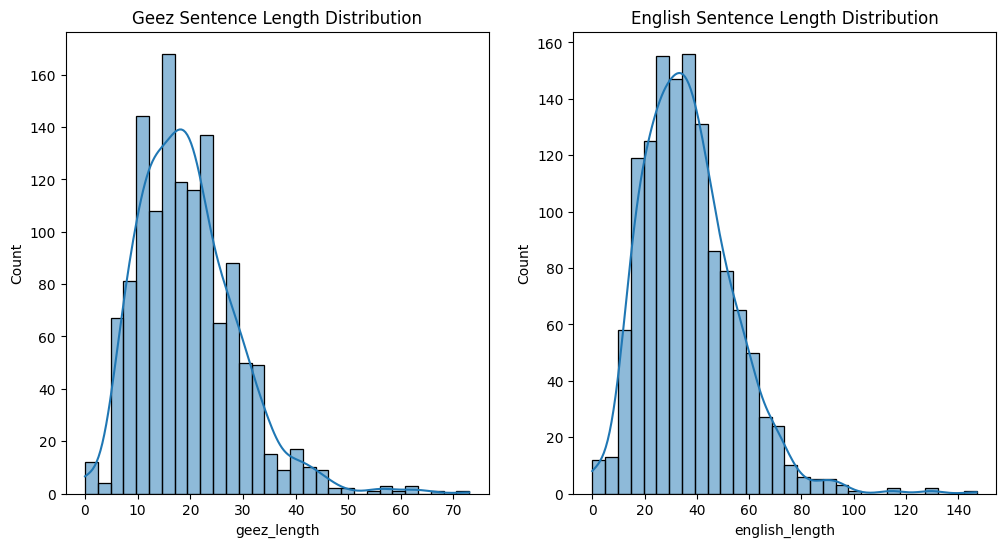

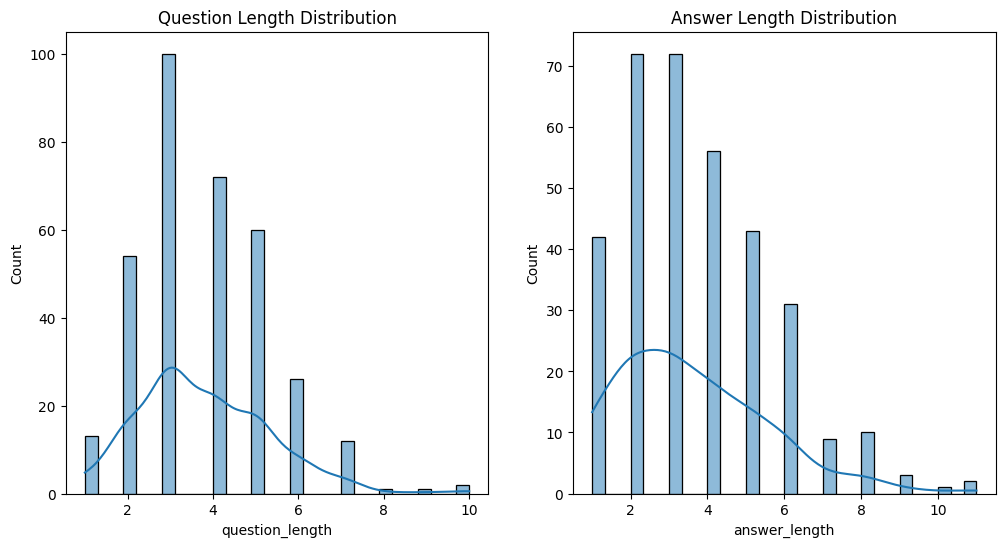

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import pandas as pd
import re

# Function for cleaning Ge'ez text (this is a repeat from your earlier code)
def clean_geez_text(text):
    """Specialized cleaner for Ge'ez text"""
    if not isinstance(text, str):
        return ''

    # Ge'ez-specific cleaning
    text = text.strip()
    text = re.sub(r'[\u1369-\u137C]', '', text)  # Remove Ethiopic numbers
    text = re.sub(r'[^\w\s\u1200-\u137F]', '', text)  # Keep only Ge'ez chars and whitespace
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text

# ====== Ensure tokens are created in both translation_df and qa_df ======

# Check if translation_df contains necessary columns
if 'gez' in translation_df.columns and 'eng' in translation_df.columns:
    translation_df['gez_cleaned'] = translation_df['gez'].apply(clean_geez_text)
    translation_df['eng_cleaned'] = translation_df['eng'].apply(clean_geez_text)

    # Tokenize the cleaned text
    translation_df['gez_tokens'] = translation_df['gez_cleaned'].apply(word_tokenize)
    translation_df['eng_tokens'] = translation_df['eng_cleaned'].apply(word_tokenize)

    # Now calculate sentence lengths
    translation_df['geez_length'] = translation_df['gez_tokens'].apply(len)
    translation_df['english_length'] = translation_df['eng_tokens'].apply(len)

else:
    print("Translation DataFrame missing 'gez' or 'eng' columns.")

# Check if qa_df contains necessary columns
if 'ጥያቄ' in qa_df.columns and 'አውስኦ' in qa_df.columns:
    qa_df['question_cleaned'] = qa_df['ጥያቄ'].apply(clean_geez_text)
    qa_df['answer_cleaned'] = qa_df['አውስኦ'].apply(clean_geez_text)

    # Tokenize the cleaned text
    qa_df['question_tokens'] = qa_df['question_cleaned'].apply(word_tokenize)
    qa_df['answer_tokens'] = qa_df['answer_cleaned'].apply(word_tokenize)

    # Now calculate sentence lengths
    qa_df['question_length'] = qa_df['question_tokens'].apply(len)
    qa_df['answer_length'] = qa_df['answer_tokens'].apply(len)

else:
    print("Q&A DataFrame missing 'ጥያቄ' or 'አውስኦ' columns.")

# ====== Plotting sentence length distributions ======

# Translation data plots
if all(col in translation_df.columns for col in ['geez_length', 'english_length']):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(translation_df['geez_length'], bins=30, kde=True)
    plt.title('Geez Sentence Length Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(translation_df['english_length'], bins=30, kde=True)
    plt.title('English Sentence Length Distribution')
    plt.show()
else:
    print("Warning: 'geez_length' or 'english_length' columns missing in translation_df")

# Q&A data plots
if all(col in qa_df.columns for col in ['question_length', 'answer_length']):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(qa_df['question_length'], bins=30, kde=True)
    plt.title('Question Length Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(qa_df['answer_length'], bins=30, kde=True)
    plt.title('Answer Length Distribution')
    plt.show()
else:
    print("Warning: 'question_length' or 'answer_length' columns missing in qa_df")


In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Custom Geez tokenizer
def geez_tokenizer(text):
    tokens = re.findall(r'[\w፩፪፫፬፭፮፯፰፱፲፳፴፵፶፷፸፹፺፻፼]+|[^\w\s]', text)
    return tokens

# Specify the correct path to your JSON and CSV files
translation_file_path = 'Kufale.json'  # Adjust if necessary
qa_file_path = 'ግዕዝ_ጥያቄ_ወአውስኦ.csv'  # Adjust if necessary

# Load translation data
translation_df = pd.read_json(translation_file_path)
print("Columns in translation_df:", translation_df.columns.tolist())  # Print columns

# Check the first few rows of the DataFrame to understand its structure
print(translation_df.head())

# Process the translation DataFrame
if 'geez' in translation_df.columns:
    translation_df['geez_tokens'] = translation_df['geez'].apply(geez_tokenizer)
    translation_df['geez_length'] = translation_df['geez_tokens'].apply(len)
else:
    print("Column 'geez' not found in translation_df")

# Load your QA data from CSV
qa_df = pd.read_csv(qa_file_path)

# Check the columns of qa_df
print("Columns in qa_df:", qa_df.columns.tolist())

# Continue with your processing...
if 'ጥያቄ' in qa_df.columns:
    qa_df['question_tokens'] = qa_df['ጥያቄ'].apply(geez_tokenizer)
    qa_df['question_length'] = qa_df['question_tokens'].apply(len)
else:
    print("Column 'ጥያቄ' not found in qa_df")

# Output the DataFrames for verification
print(translation_df)
print(qa_df)

Columns in translation_df: ['gez', 'eng']
                                                 gez  \
0  ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለ...   
1  ወኮነ በቀዳሚ ዓመት በፀአቶሙ ለደቂቀ እስራኤል እምነ ግብጽ በወርኅ ሣልስ...   
2  ወዐርገ ሙሴ ውስተ ደብረ እግዚአብሔር ወኀደረ ስብሐተ እግዚአብሔር ውስተ ...   
3  ወጸውዖ ለሙሴ በዕለተ ሳብዕት በማእከለ ደመና ወርእየ ስብሐተ እግዚአብሔር...   
4  ወሀሎ ሙሴ ውስተ ደብር አርብዓ ዕለተ ወአርብዓ ሌሊተ ወአመሮ እግዚአብሔር...   

                                                 eng  
0  These are the words regarding the divisions of...  
1  During the first year of the Israelites’ exodu...  
2  So Moses went up the mountain of the Lord. The...  
3  When he summoned Moses into the cloud on the s...  
4  Moses remained on the mountain for 40 days and...  
Column 'geez' not found in translation_df
Columns in qa_df: ['ጥያቄ', 'አውስኦ']
                                                    gez  \
0     ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለ...   
1     ወኮነ በቀዳሚ ዓመት በፀአቶሙ ለደቂቀ እስራኤል እምነ ግብጽ በወርኅ ሣልስ...   
2     ወዐርገ ሙሴ ውስተ ደብረ እግዚአብሔር ወኀደረ ስብሐ

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Training Strategy

In [ ]:
# Import necessary libraries
import pandas as pd
from transformers import AutoTokenizer
from datasets import Dataset
import json

# Initialize tokenizer for MT5
tokenizer = AutoTokenizer.from_pretrained("google/mt5-small")

# Load the CSV file for Geez question and answer dataset
csv_file_path = "ግዕዝ_ጥያቄ_ወአውስኦ.csv"
qa_df = pd.read_csv(csv_file_path)

# Drop any missing values in the QA dataset
qa_df = qa_df.dropna(subset=['ጥያቄ', 'አውስኦ'])

# Load the JSON file for Geez to English sentence pairs
json_file_path = "Kufale.json"
with open(json_file_path, 'r', encoding='utf-8') as f:
    geez_english_data = json.load(f)

# Convert JSON data into a pandas DataFrame
geez_english_df = pd.DataFrame(geez_english_data)

# Drop any missing values in the translation dataset
geez_english_df = geez_english_df.dropna(subset=['gez', 'eng'])

# ------ 1. Tokenizing Data for MT5 Model (Translation) ------

def tokenize_translation_function(examples):
    model_inputs = tokenizer(
        examples['gez'],
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['eng'],
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Convert the Geez-English sentence pair DataFrame into HuggingFace dataset format
geez_english_dataset = Dataset.from_pandas(geez_english_df)

# Tokenize the Geez-English translation dataset
tokenized_translation = geez_english_dataset.map(tokenize_translation_function, batched=True)

# Check the tokenized data (first entry)
print(tokenized_translation[0])

# ------ 2. Tokenizing Data for QA Fine-Tuning ------

def tokenize_qa_function(examples):
    model_inputs = tokenizer(
        examples['ጥያቄ'],
        max_length=128,
        truncation=True,
        padding="max_length"
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples['አውስኦ'],
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Convert the QA dataset into HuggingFace dataset format
qa_dataset = Dataset.from_pandas(qa_df)

# Tokenize the QA dataset
tokenized_qa = qa_dataset.map(tokenize_qa_function, batched=True)

# Check the tokenized QA data (first entry)
print(tokenized_qa[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1270 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'gez': 'ዝንቱ ነገረ ኩፋሌ መዋዕላተ ሕግ ወለስምዕ ለግብረ ዓመታት ለተሳብዖቶሙ ለኢዮቤልውሳቲሆሙ ውስተ ኵሉ ዓመታተ ዓለም በከመ ተናገሮ ለሙሴ በደብረ ሲና አመ ዐርገ ይንሣእ ጽላተ እብን ሕግ ወትእዛዝ በቃለ እግዚአብሔር በከመ ይቤሎ ይዕርግ ውስተ ርእሰ ደብር።', 'eng': 'These are the words regarding the divisions of the times of the law and of the testimony, of the events of the years, of the weeks of their jubilees throughout all the years of eternity as he related (them) to Moses on Mt. Sinai when he went up to receive the stone tablets — the law and the commandments — on the Lord’s orders as he had told him that he should come up to the summit of the mountain.', '__index_level_0__': 0, 'input_ids': [9660, 1157, 5644, 7829, 112933, 259, 9516, 7698, 7234, 2338, 4921, 5098, 2423, 5359, 18362, 1840, 5534, 109195, 1116, 5098, 7958, 1840, 44595, 9662, 67215, 986, 152639, 3562, 2204, 181814, 7009, 7370, 7958, 39329, 10665, 19005, 1305, 1984, 3562, 5025, 6779, 7370, 259, 9940, 5359, 259, 203467, 3328, 9662, 67215, 5359, 9662, 13659, 1365, 7728, 6169, 5956, 102173, 4992, 7958, 7370

Map:   0%|          | 0/341 [00:00<?, ? examples/s]

{'ጥያቄ': 'እፎ ሀደርከ?', 'አውስኦ': 'እግዚኣብሔር ይሴባህ፣እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ ።', 'input_ids': [2850, 32662, 32187, 22414, 7728, 291, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [2850, 1840, 4010, 12160, 25001, 1557, 3303, 17384, 2994, 1973, 4015, 109256, 5131, 5098, 1365

## Convert All Data to Seq2Seq Format

In [ ]:
import pandas as pd

# Load Q&A data
qa_df = pd.read_csv("ግዕዝ_ጥያቄ_ወአውስኦ.csv")
qa_data = [{"source": q, "target": a} for q, a in zip(qa_df["ጥያቄ"], qa_df["አውስኦ"])]

# Load translation data
trans_df = pd.read_json("Kufale.json")
trans_data = [{"source": g, "target": e} for g, e in zip(trans_df["gez"], trans_df["eng"])]

# Load Tigrigna data (adjust column names)
tig_df = pd.read_csv("geez_tigrigna.csv")
tig_data = [{"source": g, "target": t} for g, t in zip(tig_df["ግዕዝ "], tig_df["ትግርኛ "])]

# Combine all datasets (fine-tune on Q&A, pretrain on others)
combined_data = qa_data + trans_data + tig_data

In [ ]:
from transformers import MT5Tokenizer, MT5ForConditionalGeneration
tokenizer = MT5Tokenizer.from_pretrained("google/mt5-small")
model = MT5ForConditionalGeneration.from_pretrained("google/mt5-small")

# Tokenize function
def tokenize(example):
    input_enc = tokenizer(
        text=example["source"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    target_enc = tokenizer(
        text=example["target"],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Remove the batch dimension added by return_tensors="pt"
    input_enc = {k: v.squeeze() for k, v in input_enc.items()}
    target_ids = target_enc["input_ids"].squeeze()

    return {
        "input_ids": input_enc["input_ids"],
        "attention_mask": input_enc["attention_mask"],
        "labels": target_ids
    }


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.
You are using the default legacy behaviour of the <class 'transformers.models.mt5.tokenization_mt5.MT5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
 pip install amseg


  Preparing metadata (setup.py) ... done
  Created wheel for amseg: filename=amseg-2.3-py3-none-any.whl size=9771 sha256=1f25c6ec7211f82145595c7473cf37ba7299f783e7ea6595db0e743bf94bf569
  Stored in directory: /root/.cache/pip/wheels/df/9c/55/1368cec635d34f48f9ad4c7ae04d120b7acea9e371f3974d6f
Successfully built amseg


In [ ]:
import pandas as pd

def load_data_safely():
    try:
        # Load Q&A data with explicit encoding
        qa_df = pd.read_csv("ግዕዝ_ጥያቄ_ወአውስኦ.csv", encoding='utf-8')

        # Verify columns exist
        if not all(col in qa_df.columns for col in ["ጥያቄ", "አውስኦ"]):
            print("Q&A CSV columns not found. Actual columns:", qa_df.columns.tolist())
            return None

        qa_data = [{"source": str(q), "target": str(a)}
                  for q, a in zip(qa_df["ጥያቄ"], qa_df["አውስኦ"])
                  if pd.notna(q) and pd.notna(a)]

        # Load translation data
        trans_df = pd.read_json("Kufale.json")

        if not all(col in trans_df.columns for col in ["gez", "eng"]):
            print("Translation JSON columns not found. Actual columns:", trans_df.columns.tolist())
            return None

        trans_data = [{"source": str(g), "target": str(e)}
                     for g, e in zip(trans_df["gez"], trans_df["eng"])
                     if pd.notna(g) and pd.notna(e)]

        # Load Tigrigna data
        tig_df = pd.read_csv("geez_tigrigna.csv", encoding='utf-8')

        if not all(col in tig_df.columns for col in ["ግዕዝ ", "ትግርኛ "]):
            print("Tigrigna CSV columns not found. Actual columns:", tig_df.columns.tolist())
            return None

        tig_data = [{"source": str(g), "target": str(t)}
                   for g, t in zip(tig_df["ግዕዝ "], tig_df["ትግርኛ "])
                   if pd.notna(g) and pd.notna(t)]

        # Combine all datasets
        combined_data = qa_data + trans_data + tig_data
        print(f"Successfully loaded: {len(qa_data)} QA pairs, {len(trans_data)} translations, {len(tig_data)} Tigrigna pairs")
        return combined_data

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Usage
combined_data = load_data_safely()
if combined_data:
    print(f"Total combined samples: {len(combined_data)}")
    print("First sample:", combined_data[0])
else:
    print("Failed to load data")

Successfully loaded: 341 QA pairs, 1270 translations, 4504 Tigrigna pairs
Total combined samples: 6115
First sample: {'source': 'እፎ ሀደርከ?', 'target': 'እግዚኣብሔር ይሴባህ፣እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ ።'}


## Enhanced Data Cleaning Pipeline

In [ ]:
import pandas as pd
import re
from transformers import MT5Tokenizer, MT5ForConditionalGeneration

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Normalize Geez punctuation
    text = re.sub(r'[።፣፤፥]', lambda x: {'።': '.', '፣': ',', '፤': ';', '፥': ':'}[x.group()], text)

    # Remove duplicate punctuation
    text = re.sub(r'([.,!?:])\1+', r'\1', text)

    # Standardize whitespace around punctuation
    text = re.sub(r'\s*([.,!?:])\s*', r'\1 ', text)

    return text.strip()

def load_and_clean_data():
    try:
        # Load datasets with explicit encoding
        qa_df = pd.read_csv("ግዕዝ_ጥያቄ_ወአውስኦ.csv", encoding='utf-8')
        trans_df = pd.read_json("Kufale.json")
        tig_df = pd.read_csv("geez_tigrigna.csv", encoding='utf-8')

        # Standardize column names
        qa_df = qa_df.rename(columns={"ጥያቄ": "source", "አውስኦ": "target"})
        trans_df = trans_df.rename(columns={"gez": "source", "eng": "target"})
        tig_df = tig_df.rename(columns={"ግዕዝ ": "source", "ትግርኛ ": "target"})

        # Combine datasets
        combined_df = pd.concat([
            qa_df[["source", "target"]],
            trans_df[["source", "target"]],
            tig_df[["source", "target"]]
        ], ignore_index=True)

        # Advanced cleaning
        combined_df["source_clean"] = combined_df["source"].apply(clean_text)
        combined_df["target_clean"] = combined_df["target"].apply(clean_text)

        # Remove empty strings, NA values, and duplicates
        combined_df = combined_df[
            (combined_df["source_clean"].str.len() > 0) &
            (combined_df["target_clean"].str.len() > 0)
        ].dropna().drop_duplicates()

        # Validate lengths (adjust max_length as needed)
        max_length = 128
        combined_df = combined_df[
            (combined_df["source_clean"].str.split().str.len() <= max_length) &
            (combined_df["target_clean"].str.split().str.len() <= max_length)
        ]

        print(f"Final dataset size: {len(combined_df)}")
        print("Sample cleaned data:")
        print(combined_df[["source_clean", "target_clean"]].head())

        return combined_df

    except Exception as e:
        print(f"Error loading or cleaning data: {str(e)}")
        return None

def initialize_model():
    try:
        model_name = "google/mt5-small"

        # Initialize tokenizer with proper settings for Geez
        tokenizer = MT5Tokenizer.from_pretrained(
            model_name,
            tokenizer_class=MT5Tokenizer,
            legacy=False,
            truncation=True,
            model_max_length=128
        )

        # Corrected special tokens (fixed syntax error)
        special_tokens = ["<gee>", "</gee>", "<tig>", "</tig>", "<eng>", "</eng>"]
        tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})

        # Initialize model
        model = MT5ForConditionalGeneration.from_pretrained(model_name)

        # Resize embeddings if special tokens were added
        model.resize_token_embeddings(len(tokenizer))

        print("Tokenizer and model initialized successfully")
        print(f"Tokenizer vocab size: {len(tokenizer)}")

        return tokenizer, model

    except Exception as e:
        print(f"Error initializing model: {str(e)}")
        return None, None

# Execute the pipeline
cleaned_data = load_and_clean_data()
if cleaned_data is not None:
    tokenizer, model = initialize_model()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MT5Tokenizer'.


Final dataset size: 6079
Sample cleaned data:
    source_clean                               target_clean
0       እፎ ሀደርከ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
1       እፎ ወዓልከ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
2    ሰላም ለከ እሁየ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
3  ኦ ኡሁየ መኑ ስምከ?                            ስምየ ሰሎሞን ይትበሃል.
4     ማዕዜ ተወለድከ?                ዘተወለድኩ በ፲፱፻፺፫ ዓመተ ምህረት ውእቱ.
Tokenizer and model initialized successfully
Tokenizer vocab size: 250106


## data preparation

In [ ]:
from datasets import Dataset
import numpy as np
from transformers import DataCollatorForSeq2Seq

def verify_dataset(dataset):
    """Validate dataset quality before training"""
    print("\nDataset Verification Report:")
    print(f"Total samples: {len(dataset)}")

    # Check sample lengths
    source_lens = [len(x.split()) for x in dataset["source"]]
    target_lens = [len(x.split()) for x in dataset["target"]]

    print(f"Source length - Avg: {np.mean(source_lens):.1f}, Max: {max(source_lens)}")
    print(f"Target length - Avg: {np.mean(target_lens):.1f}, Max: {max(target_lens)}")

    # Check token distribution
    sample_text = dataset["source"][0]
    print("\nSample tokenization check:")
    print(f"Original: {sample_text}")
    print(f"Tokenized: {tokenizer.tokenize(sample_text)}")
    print(f"Decoded: {tokenizer.decode(tokenizer.encode(sample_text))}")

def preprocess_function(examples):
    """Enhanced preprocessing with validation"""
    try:
        # Convert to strings and validate
        inputs = [str(src) if src is not None else "" for src in examples['source']]
        targets = [str(tgt) if tgt is not None else "" for tgt in examples['target']]

        # Tokenize with text_target instead of as_target_tokenizer
        model_inputs = tokenizer(
            inputs,
            max_length=128,
            truncation=True,
            padding="max_length"
        )

        # Tokenize targets using text_target parameter
        labels = tokenizer(
            text_target=targets,
            max_length=128,
            truncation=True,
            padding="max_length"
        )

        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    except Exception as e:
        print(f"Error in preprocessing: {e}")
        raise

# Convert pandas DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(cleaned_data[['source_clean', 'target_clean']])
dataset = dataset.rename_columns({'source_clean': 'source', 'target_clean': 'target'})

# Add task prefixes
def add_task_prefix(example):
    if "?" in example["source"]:  # Q&A
        example["source"] = "<gee> " + example["source"]
    elif any(c in example["target"] for c in ["።", "፣"]):  # Geez-English
        example["source"] = "<gee><eng> " + example["source"]
    else:  # Geez-Tigrinya
        example["source"] = "<gee><tig> " + example["source"]
    return example

dataset = dataset.map(add_task_prefix)

# Verify before preprocessing
verify_dataset(dataset)

# Apply preprocessing
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    batch_size=32,
    remove_columns=dataset.column_names
)

# Data Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)

# Final checks (updated to handle lists)
print("\nPreprocessed Sample:")
sample = tokenized_dataset[0]
print("Input IDs length:", len(sample["input_ids"]))
print("Attention mask length:", len(sample["attention_mask"]))
print("Labels length:", len(sample["labels"]))
print("Decoded input:", tokenizer.decode(sample["input_ids"]))
print("Decoded label:", tokenizer.decode(sample["labels"]))

Map:   0%|          | 0/6079 [00:00<?, ? examples/s]


Dataset Verification Report:
Total samples: 6079
Source length - Avg: 6.1, Max: 73
Target length - Avg: 9.3, Max: 128

Sample tokenization check:
Original: <gee> እፎ ሀደርከ?
Tokenized: ['<gee>', '▁እ', 'ፎ', '▁ሀ', 'ደር', 'ከ', '?']
Decoded: <gee> እፎ ሀደርከ?</s>


Map:   0%|          | 0/6079 [00:00<?, ? examples/s]


Preprocessed Sample:
Input IDs length: 128
Attention mask length: 128
Labels length: 128
Decoded input: <gee> እፎ ሀደርከ?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Decoded label: እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

# split data

Final dataset size: 6079
Sample cleaned data:
    source_clean                               target_clean
0       እፎ ሀደርከ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
1       እፎ ወዓልከ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
2    ሰላም ለከ እሁየ?  እግዚኣብሔር ይሴባህ, እንቃዕ በሰላም መጻእከ ሀበ ልሳንነ ግዕዝ.
3  ኦ ኡሁየ መኑ ስምከ?                            ስምየ ሰሎሞን ይትበሃል.
4     ማዕዜ ተወለድከ?                ዘተወለድኩ በ፲፱፻፺፫ ዓመተ ምህረት ውእቱ.

Data split complete:
Training samples: 4863
Validation samples: 1216


Tokenizing datasets:   0%|          | 0/4863 [00:00<?, ? examples/s]

Tokenizing datasets:   0%|          | 0/1216 [00:00<?, ? examples/s]


Sample training example:
Input IDs: [54437, 2474, 7728, 1, 0, 0, 0, 0, 0, 0]... (length: 128)
Decoded: አምለከ...


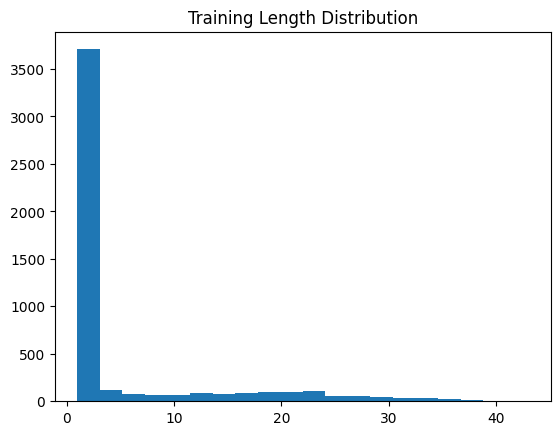

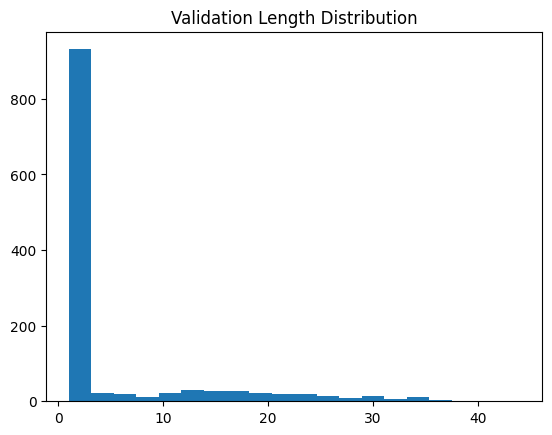

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd

def prepare_datasets(combined_df, test_size=0.2, random_state=42):
    """
    Prepares train/validation datasets with proper splitting and preprocessing

    Args:
        combined_df: Pandas DataFrame with 'source' and 'target' columns
        test_size: Fraction for validation (default: 0.2)
        random_state: Random seed (default: 42)

    Returns:
        DatasetDict with tokenized train/validation sets
    """
    try:
        # 1. Validate input
        assert {'source', 'target'}.issubset(combined_df.columns)
        assert 0 < test_size < 1

        # 2. Split data (stratify by task type if available)
        stratify = combined_df.get('task_type')
        train_df, eval_df = train_test_split(
            combined_df,
            test_size=test_size,
            random_state=random_state,
            stratify=stratify
        )

        print(f"\nData split complete:")
        print(f"Training samples: {len(train_df)}")
        print(f"Validation samples: {len(eval_df)}")


        # 3. Convert to HuggingFace datasets
        raw_datasets = DatasetDict({
            'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
            'validation': Dataset.from_pandas(eval_df.reset_index(drop=True))
        })

        # 4. Apply preprocessing
        tokenized_datasets = raw_datasets.map(
            preprocess_function,
            batched=True,
            batch_size=512,
            remove_columns=raw_datasets['train'].column_names,
            desc="Tokenizing datasets"
        )

        return tokenized_datasets

    except Exception as e:
        print(f"\nError preparing datasets: {str(e)}")
        raise

# Execute the full pipeline
if __name__ == "__main__":
    # 1. Load and clean data
    cleaned_data = load_and_clean_data()

    if cleaned_data is not None:
        # 2. Add task identifiers
        cleaned_data['task_type'] = cleaned_data['source'].apply(
            lambda x: 'qa' if '?' in str(x) else ('trans' if any(c in str(x) for c in ['።', '፣']) else 'tigrinya')
        )

        # 3. Prepare datasets
        tokenized_datasets = prepare_datasets(cleaned_data)

        # 4. Verification
        print("\nSample training example:")
        sample = tokenized_datasets['train'][0]
        print(f"Input IDs: {sample['input_ids'][:10]}... (length: {len(sample['input_ids'])})")
        print(f"Decoded: {tokenizer.decode(sample['input_ids'][:10], skip_special_tokens=True)}...")


def plot_lengths(dataset, title):
    lengths = [len(tokenizer.decode(x['input_ids'], skip_special_tokens=True).split())
               for x in dataset]
    plt.hist(lengths, bins=20)
    plt.title(f'{title} Length Distribution')
    plt.show()

plot_lengths(tokenized_datasets['train'], "Training")
plot_lengths(tokenized_datasets['validation'], "Validation")

In [ ]:
!pip install evaluate
!pip install sacrebleu
!pip install bert_score
!pip install -U transformers
!pip install rouge_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d501374e926a8e60b9c8db7df905e94cda92263579ef271272724279c757472c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!rm -rf ./gee_chatbot_model


In [ ]:
from transformers import (
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq, EarlyStoppingCallback,
    AutoModelForSeq2SeqLM, AutoTokenizer
)
from datasets import Dataset
from evaluate import load
import numpy as np
import torch
import pandas as pd
import json
import warnings
import shutil
import os
from datetime import datetime

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ======================
# 0. Configuration
# ======================
MODEL_NAME = "google/mt5-small"
MAX_LENGTH = 128
BATCH_SIZE = 4  # Adjust based on GPU memory
GRAD_ACCUM_STEPS = 4
NUM_EPOCHS = 10
LEARNING_RATE = 2e-5  # Reduced learning rate for stability

# Clean up previous training artifacts
PREVIOUS_OUTPUT_DIRS = [
    "./geez-mt5-finetuned",
    "./geez-mt5-final",
    "./geez-mt5-checkpoint",
    "./logs"
]

print("\nCleaning up previous training artifacts...")
for dir_path in PREVIOUS_OUTPUT_DIRS:
    if os.path.exists(dir_path):
        try:
            shutil.rmtree(dir_path)
            print(f"Deleted: {dir_path}")
        except Exception as e:
            print(f"Error deleting {dir_path}: {str(e)}")
    else:
        print(f"Directory not found: {dir_path}")

# Create fresh output directories with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"./geez-mt5-finetuned-{timestamp}"
FINAL_MODEL_DIR = f"./geez-mt5-final-{timestamp}"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)

# Clear PyTorch cache
torch.cuda.empty_cache()

# ======================
# 1. Data Loading (Improved Version)
# ======================
def load_data_safely():
    try:
        # Load Q&A data with explicit encoding
        qa_df = pd.read_csv("/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv", encoding='utf-8')

        # Verify columns exist
        if not all(col in qa_df.columns for col in ["ጥያቄ", "አውስኦ"]):
            print("Q&A CSV columns not found. Actual columns:", qa_df.columns.tolist())
            return None

        qa_data = [{"source": str(q), "target": str(a), "task": "qa"}
                  for q, a in zip(qa_df["ጥያቄ"], qa_df["አውስኦ"])
                  if pd.notna(q) and pd.notna(a)]

        # Load translation data
        with open("/content/Kufale.json", 'r', encoding='utf-8') as f:
            trans_df = pd.DataFrame(json.load(f))

        if not all(col in trans_df.columns for col in ["gez", "eng"]):
            print("Translation JSON columns not found. Actual columns:", trans_df.columns.tolist())
            return None

        trans_data = [{"source": str(g), "target": str(e), "task": "en"}
                     for g, e in zip(trans_df["gez"], trans_df["eng"])
                     if pd.notna(g) and pd.notna(e)]

        # Load Tigrigna data
        tig_df = pd.read_csv("/content/geez_tigrigna.csv", encoding='utf-8')

        if not all(col in tig_df.columns for col in ["ግዕዝ ", "ትግርኛ "]):
            print("Tigrigna CSV columns not found. Actual columns:", tig_df.columns.tolist())
            return None

        tig_data = [{"source": str(g).strip(), "target": str(t).strip(), "task": "tig"}
                   for g, t in zip(tig_df["ግዕዝ "], tig_df["ትግርኛ "])
                   if pd.notna(g) and pd.notna(t)]

        # Combine all datasets
        combined_data = qa_data + trans_data + tig_data
        print(f"Successfully loaded: {len(qa_data)} QA pairs, {len(trans_data)} translations, {len(tig_data)} Tigrigna pairs")
        return combined_data

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# ======================
# 2. Initialize Model & Tokenizer (Improved Version)
# ======================
print("\nInitializing fresh model and tokenizer...")

# Force new download and initialization
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, force_download=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, legacy=False, use_fast=True, force_download=True)

# Verify fresh initialization
print(f"Model device: {next(model.parameters()).device}")
print(f"Model config: {model.config}")

# Add custom tokens
geez_numerals = ["፩", "፪", "፫", "፬", "፭", "፮", "፯", "፰", "፱", "፲", "፳", "፴", "፵", "፶", "፷", "፸", "፹", "፺", "፻", "፼"]
task_prefixes = ["<geez_qa>", "<geez_en>", "<geez_tig>"]
tokenizer.add_tokens(geez_numerals + task_prefixes)

# Properly resize embeddings with initialization check
original_vocab_size = model.config.vocab_size
original_embeddings = model.get_input_embeddings().weight.clone()
model.resize_token_embeddings(len(tokenizer))

# Initialize new embeddings properly
with torch.no_grad():
    # Get the current embeddings after resizing
    new_embeddings = model.get_input_embeddings().weight

    # Verify sizes match
    if original_embeddings.shape[0] > new_embeddings.shape[0]:
        # If original is larger (shouldn't happen), truncate
        original_embeddings = original_embeddings[:new_embeddings.shape[0]]
    elif original_embeddings.shape[0] < new_embeddings.shape[0]:
        # If new embeddings is larger (expected case), pad original with zeros
        padding_size = new_embeddings.shape[0] - original_embeddings.shape[0]
        padding = torch.zeros((padding_size, original_embeddings.shape[1]),
                            device=original_embeddings.device)
        original_embeddings = torch.cat([original_embeddings, padding], dim=0)

    # Copy original embeddings
    new_embeddings[:] = original_embeddings[:new_embeddings.shape[0]]

    # Random initialization for new tokens if we added any
    if len(tokenizer) > original_vocab_size:
        new_tokens_count = len(tokenizer) - original_vocab_size
        new_embeddings[original_vocab_size:] = torch.normal(
            mean=0.0,
            std=0.02,
            size=(new_tokens_count, new_embeddings.shape[1]),
            device=new_embeddings.device,
            dtype=new_embeddings.dtype
        )

print(f"Added {len(geez_numerals + task_prefixes)} new tokens")
print(f"Original vocab size: {original_vocab_size}, New vocab size: {len(tokenizer)}")
print(f"Embeddings shape: {model.get_input_embeddings().weight.shape}")
# ======================
# 3. Load and Prepare Datasets
# ======================
print("\nLoading datasets...")
combined_data = load_data_safely()
if not combined_data:
    raise ValueError("Failed to load data - check error messages above")

# Convert to Dataset and split
dataset = Dataset.from_list(combined_data)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# ======================
# 4. Preprocessing Function (Improved Version)
# ======================
def preprocess_function(examples):
    # Add task prefixes
    inputs = []
    for src, task in zip(examples["source"], examples["task"]):
        if task == "qa":
            inputs.append(f"<geez_qa> {src}")
        elif task == "en":
            inputs.append(f"<geez_en> {src}")
        else:
            inputs.append(f"<geez_tig> {src}")

    targets = [str(tgt) for tgt in examples["target"]]

    # Tokenize with error handling
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    # Tokenize targets separately
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=MAX_LENGTH,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

    # Replace padding with -100 for loss calculation
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels
    }

# ======================
# 5. Tokenize Datasets with Debugging
# ======================
print("\nTokenizing datasets...")
tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    batch_size=512,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing"
)

# Debug samples
print("\nSample tokenized data:")
for i in range(min(3, len(tokenized_datasets["train"]))):
    print(f"Input: {tokenizer.decode(tokenized_datasets['train'][i]['input_ids'], skip_special_tokens=True)}")
    print(f"Label: {tokenizer.decode([x for x in tokenized_datasets['train'][i]['labels'] if x != -100], skip_special_tokens=True)}\n")

# ======================
# 6. Training Setup (Improved Version)
# ======================
print("\nSetting up training...")
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,  # Using our new timestamped directory
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    weight_decay=0.01,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    generation_max_length=MAX_LENGTH,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs",
    logging_steps=100,
    report_to="tensorboard",
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    lr_scheduler_type="linear",
    warmup_steps=500,
    optim="adamw_torch",
    max_grad_norm=0.5,  # More aggressive gradient clipping
    save_total_limit=1,  # Only keep the best model
    seed=42,
    label_smoothing_factor=0.1,
    gradient_checkpointing=True,
    overwrite_output_dir=True  # Ensure we can write to the directory
)

# Initialize metrics
bleu_metric = load("sacrebleu")
rouge_metric = load("rouge")

def compute_metrics(eval_preds):
    try:
        preds, labels = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]

        # Decode predictions and labels
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

        # Replace -100 with pad token id in labels
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

        # Clean whitespace
        decoded_preds = [pred.strip() for pred in decoded_preds]
        decoded_labels = [[label.strip()] for label in decoded_labels]

        # Debug prints
        print("\nSample evaluation:")
        for i in range(min(2, len(decoded_preds))):
            print(f"Prediction: {decoded_preds[i]}")
            print(f"Reference: {decoded_labels[i][0]}\n")

        # Compute BLEU
        bleu_result = bleu_metric.compute(
            predictions=decoded_preds,
            references=decoded_labels
        )

        # Compute ROUGE
        rouge_result = rouge_metric.compute(
            predictions=decoded_preds,
            references=decoded_labels,
            use_stemmer=True,
            use_aggregator=True
        )

        # Extract ROUGE scores
        rouge_scores = {
            "rouge1": rouge_result["rouge1"].mid.fmeasure * 100,
            "rouge2": rouge_result["rouge2"].mid.fmeasure * 100,
            "rougeL": rouge_result["rougeL"].mid.fmeasure * 100
        }

        return {
            "bleu": bleu_result["score"],
            **rouge_scores
        }
    except Exception as e:
        print(f"Error in compute_metrics: {str(e)}")
        return {
            "bleu": 0.0,
            "rouge1": 0.0,
            "rouge2": 0.0,
            "rougeL": 0.0
        }

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=DataCollatorForSeq2Seq(
        tokenizer,
        model=model,
        pad_to_multiple_of=8
    ),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ======================
# 7. Training Execution (Improved Version)
# ======================
print(f"\nStarting fresh training in directory: {OUTPUT_DIR}")
try:
    # Verify everything is set up correctly
    print("\nPre-training verification:")
    print(f"Training samples: {len(tokenized_datasets['train'])}")
    print(f"Evaluation samples: {len(tokenized_datasets['test'])}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Current GPU memory: {torch.cuda.memory_allocated()/1024**2:.2f} MB")

    # Train
    train_result = trainer.train()

    print("\nTraining completed successfully!")
    print(f"Final training loss: {train_result.training_loss}")

    # Evaluate
    eval_results = trainer.evaluate()
    print("\nEvaluation results:")
    print(f"BLEU: {eval_results['bleu']:.2f}")
    print(f"ROUGE-1: {eval_results['rouge1']:.2f}")
    print(f"ROUGE-2: {eval_results['rouge2']:.2f}")
    print(f"ROUGE-L: {eval_results['rougeL']:.2f}")

    # Save final model
    print(f"\nSaving final model to: {FINAL_MODEL_DIR}")
    trainer.save_model(FINAL_MODEL_DIR)
    tokenizer.save_pretrained(FINAL_MODEL_DIR)

    # Save training arguments and config
    trainer.save_state()
    model.config.save_pretrained(FINAL_MODEL_DIR)

    print("\nTraining artifacts saved:")
    print(f"- Model: {FINAL_MODEL_DIR}")
    print(f"- Logs: {OUTPUT_DIR}")
    print(f"- Tensorboard: ./logs")

except Exception as e:
    print(f"\nTraining failed: {str(e)}")
    # Save whatever we have
    try:
        print(f"\nAttempting to save checkpoint to: {OUTPUT_DIR}")
        trainer.save_model(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)
        print("Checkpoint saved successfully")
    except Exception as save_error:
        print(f"Failed to save checkpoint: {str(save_error)}")
    raise

finally:
    # Clean up any partial checkpoints
    print("\nCleaning up temporary files...")
    for dirpath, dirnames, filenames in os.walk(OUTPUT_DIR):
        for filename in filenames:
            if filename.startswith('checkpoint'):
                try:
                    os.remove(os.path.join(dirpath, filename))
                    print(f"Deleted temporary file: {filename}")
                except Exception as e:
                    print(f"Error deleting {filename}: {str(e)}")

print("\nTraining process completed successfully!")

In [ ]:
from transformers import (
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq, EarlyStoppingCallback,
    AutoModelForSeq2SeqLM, AutoTokenizer
)
from datasets import Dataset
from evaluate import load
import numpy as np
import torch
import pandas as pd
import json
import shutil
import warnings
import os

warnings.filterwarnings("ignore", category=UserWarning)

MODEL_NAME = "google/mt5-small"
MAX_LENGTH = 128
BATCH_SIZE = 8
GRAD_ACCUM_STEPS = 2
NUM_EPOCHS = 10
LEARNING_RATE = 3e-4

for dir_path in ["./geez-mt5-finetuned", "./geez-mt5-final", "./logs"]:
    if os.path.exists(dir_path):
        try:
            for root, dirs, files in os.walk(dir_path):
                for f in files:
                    os.unlink(os.path.join(root, f))
                for d in dirs:
                    shutil.rmtree(os.path.join(root, d))
            print(f"Cleaned {dir_path}")
        except Exception as e:
            print(f"Cleanup error: {e}")

def load_data_safely():
    try:
        qa_df = pd.read_csv("/content/ግዕዝ_ጥያቄ_ወአውስኦ.csv", encoding='utf-8')
        trans_df = pd.read_json("/content/Kufale.json")
        tig_df = pd.read_csv("/content/geez_tigrigna.csv", encoding='utf-8')

        qa_data = [{"source": str(q), "target": str(a), "task": "qa"}
                  for q, a in zip(qa_df["ጥያቄ"], qa_df["አውስኦ"])
                  if pd.notna(q) and pd.notna(a)]

        trans_data = [{"source": str(g), "target": str(e), "task": "en"}
                     for g, e in zip(trans_df["gez"], trans_df["eng"])
                     if pd.notna(g) and pd.notna(e)]

        tig_data = [{"source": str(g).strip(), "target": str(t).strip(), "task": "tig"}
                   for g, t in zip(tig_df["ግዕዝ "], tig_df["ትግርኛ "])
                   if pd.notna(g) and pd.notna(t)]

        combined_data = qa_data + trans_data + tig_data
        print(f"Loaded {len(combined_data)} total samples")
        return combined_data
    except Exception as e:
        print(f"Data loading failed: {e}")
        return None

model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

new_tokens = ["፩", "፪", "፫", "፬", "፭", "፮", "፯", "፰", "፱", "፲", "፳", "፴", "፵", "፶", "፷", "፸", "፹", "፺", "፻", "፼"] + \
             ["<geez_qa>", "<geez_en>", "<geez_tig>"]
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

def preprocess_function(examples):
    inputs = [
        f"<geez_qa> {x}" if task == "qa" else
        f"<geez_en> {x}" if task == "en" else
        f"<geez_tig> {x}"
        for x, task in zip(examples["source"], examples["task"])
    ]
    targets = [str(x) for x in examples["target"]]

    model_inputs = tokenizer(
        inputs, max_length=MAX_LENGTH, truncation=True, padding="max_length"
    )

    labels = tokenizer(
        text_target=targets, max_length=MAX_LENGTH,
        truncation=True, padding="max_length"
    )["input_ids"]

    labels = [[(l if l != tokenizer.pad_token_id else -100) for l in label]
             for label in labels]

    return {
        "input_ids": model_inputs["input_ids"],
        "attention_mask": model_inputs["attention_mask"],
        "labels": labels
    }

combined_data = load_data_safely()
dataset = Dataset.from_list(combined_data).train_test_split(test_size=0.2)
tokenized_data = dataset.map(preprocess_function, batched=True, batch_size=512)

training_args = Seq2SeqTrainingArguments(
    output_dir="./geez-mt5-finetuned",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=NUM_EPOCHS,
    predict_with_generate=True,
    generation_max_length=MAX_LENGTH,
    fp16=torch.cuda.is_available(),
    logging_dir="./logs",
    logging_steps=100,
    report_to="tensorboard",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    save_total_limit=2
)

# ✅ FIXED: Metrics without .mid.fmeasure
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    if len(decoded_preds) == 0 or len(decoded_labels) == 0:
        return {"bleu": 0.0, "rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}

    bleu = load("sacrebleu").compute(
        predictions=decoded_preds,
        references=[[x] for x in decoded_labels]
    )["score"]

    rouge = load("rouge").compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )

    return {
        "bleu": bleu,
        "rouge1": rouge["rouge1"] * 100,
        "rouge2": rouge["rouge2"] * 100,
        "rougeL": rouge["rougeL"] * 100
    }

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nStarting training...")
train_result = trainer.train()

trainer.save_model("./geez-mt5-final")
tokenizer.save_pretrained("./geez-mt5-final")
print("Training complete!")


Cleaned ./geez-mt5-finetuned
Cleaned ./logs
Loaded 6115 total samples


Map:   0%|          | 0/4892 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Map:   0%|          | 0/1223 [00:00<?, ? examples/s]


Starting training...


Step,Training Loss,Validation Loss
